# Reactive covering

## Introduction

EXPLAIN

In [2]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
from docplex.mp.model import Model

import random
import json

def showSolution(data,solution):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()

## Stage 1

Explicar como hemos calculado el coste y como hemos definido la quality y meter un poco de paja rollo intro

In [4]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)


# Very basic solver
# We start considering all the AOIs uncovered
covered = [False for i in range(nObsRequests)]
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # Try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering
quality = 0
for passId in selectedPassIds:
    timeUse = satPasses[passId]['end'] - satPasses[passId]['start']
    for accessId in satPasses[passId]['accessIds']:
        for obsRequest in obsRequests:
            if accessId in obsRequest['accessIds']:
                quality += goals[obsRequest['goalId']]['priority']*timeUse

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

IDs of the 9 selected passes: [23, 10, 15, 34, 48, 42, 37, 25, 56]
Total cost of the covering: 3735
Quality of the covering: 237047


In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 2

EXPLAIN

In [9]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)

# Parameters
maxBudget = 3735 # Modify if required

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')

# Objectif
# Computation of the quality of the covering
# AQUI HAY ALGUN FALLO
#model.maximize(model.sum(goals[obsRequest['goalId']]['priority']*(satPasses[passId]['end'] - satPasses[passId]['start'])*selectedPass[passId]*int(accessId in obsRequest['accessIds']) 
#            for passId in range(nPasses) for obsRequest in obsRequests for accessId in satPasses[passId]['accessIds']))

# Revisar
def qualityCompForPass(passId):
    quality = 0
    for accessId in satPasses[passId]['accessIds']:
        for obsRequest in obsRequests:
            if accessId in obsRequest['accessIds']:
                quality += goals[obsRequest['goalId']]['priority']*(satPasses[passId]['end'] - satPasses[passId]['start'])*selectedPass[passId]
    return quality

model.maximize(model.sum(qualityCompForPass(passId) for passId in range(nPasses)))

# Contraints:
# 1) Cost below maximum budget
#model.add_constraint(model.sum(alpha[i, b]*T[i] for i in Stations) <= Gamma)
#totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])*data['passCostPerTimeUnit']
model.add_constraint(model.sum(selectedPass)*data['fixedPassCost'] + model.sum((satPasses[id]['end'] - satPasses[id]['start'])*selectedPass[id] for id in range(nPasses)) <= maxBudget)

# Solve
# Time limitation
model.set_time_limit(60)

#model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

solution.display()

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)

# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering (NO HACE FALTA)
quality = 0
for passId in selectedPassIds:
    timeUse = satPasses[passId]['end'] - satPasses[passId]['start']
    for accessId in satPasses[passId]['accessIds']:
        for obsRequest in obsRequests:
            if accessId in obsRequest['accessIds']:
                quality += goals[obsRequest['goalId']]['priority']*timeUse

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(solution.objective_value))

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 2 rows and 4 columns.
MIP Presolve added 11 rows and 11 columns.
Reduced MIP has 10 rows, 76 columns, and 94 nonzeros.
Reduced MIP has 65 binaries, 11 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 11 rows and 11 columns.
MIP Presolve added 11 rows and 11 columns.
Reduced MIP has 10 rows, 76 columns, and 94 nonzeros.
Reduced MIP has 65 binaries, 11 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 1

Bookings:
{'passId': 2, 'passStart': 1104, 'passEnd': 1449, 'bookingStart': 1104, 'bookingEnd': 1449}
{'passId': 10, 'passStart': 6617, 'passEnd': 6964, 'bookingStart': 6617, 'bookingEnd': 6964}
{'passId': 18, 'passStart': 12132, 'passEnd': 12479, 'bookingStart': 12132, 'bookingEnd': 12479}
{'passId': 26, 'passStart': 17649, 'passEnd': 17994, 'bookingStart': 17649, 'bookingEnd': 17994}
{'passId': 34, 'passStart': 23170, 'passEnd': 23507, 'bookingStart': 23170, 'bookingEnd': 23507}
{'passId': 43, 'passStart': 28689, 'passEnd': 29021, 'bookingStart': 28689, 'bookingEnd': 29021}
{'passId': 56, 'passStart': 35877, 'passEnd': 36205, 'bookingStart': 35877, 'bookingEnd': 36205}
{'passId': 66, 'passStart': 41390, 'passEnd': 41725, 'bookingStart': 41390, 'bookingEnd': 41725}


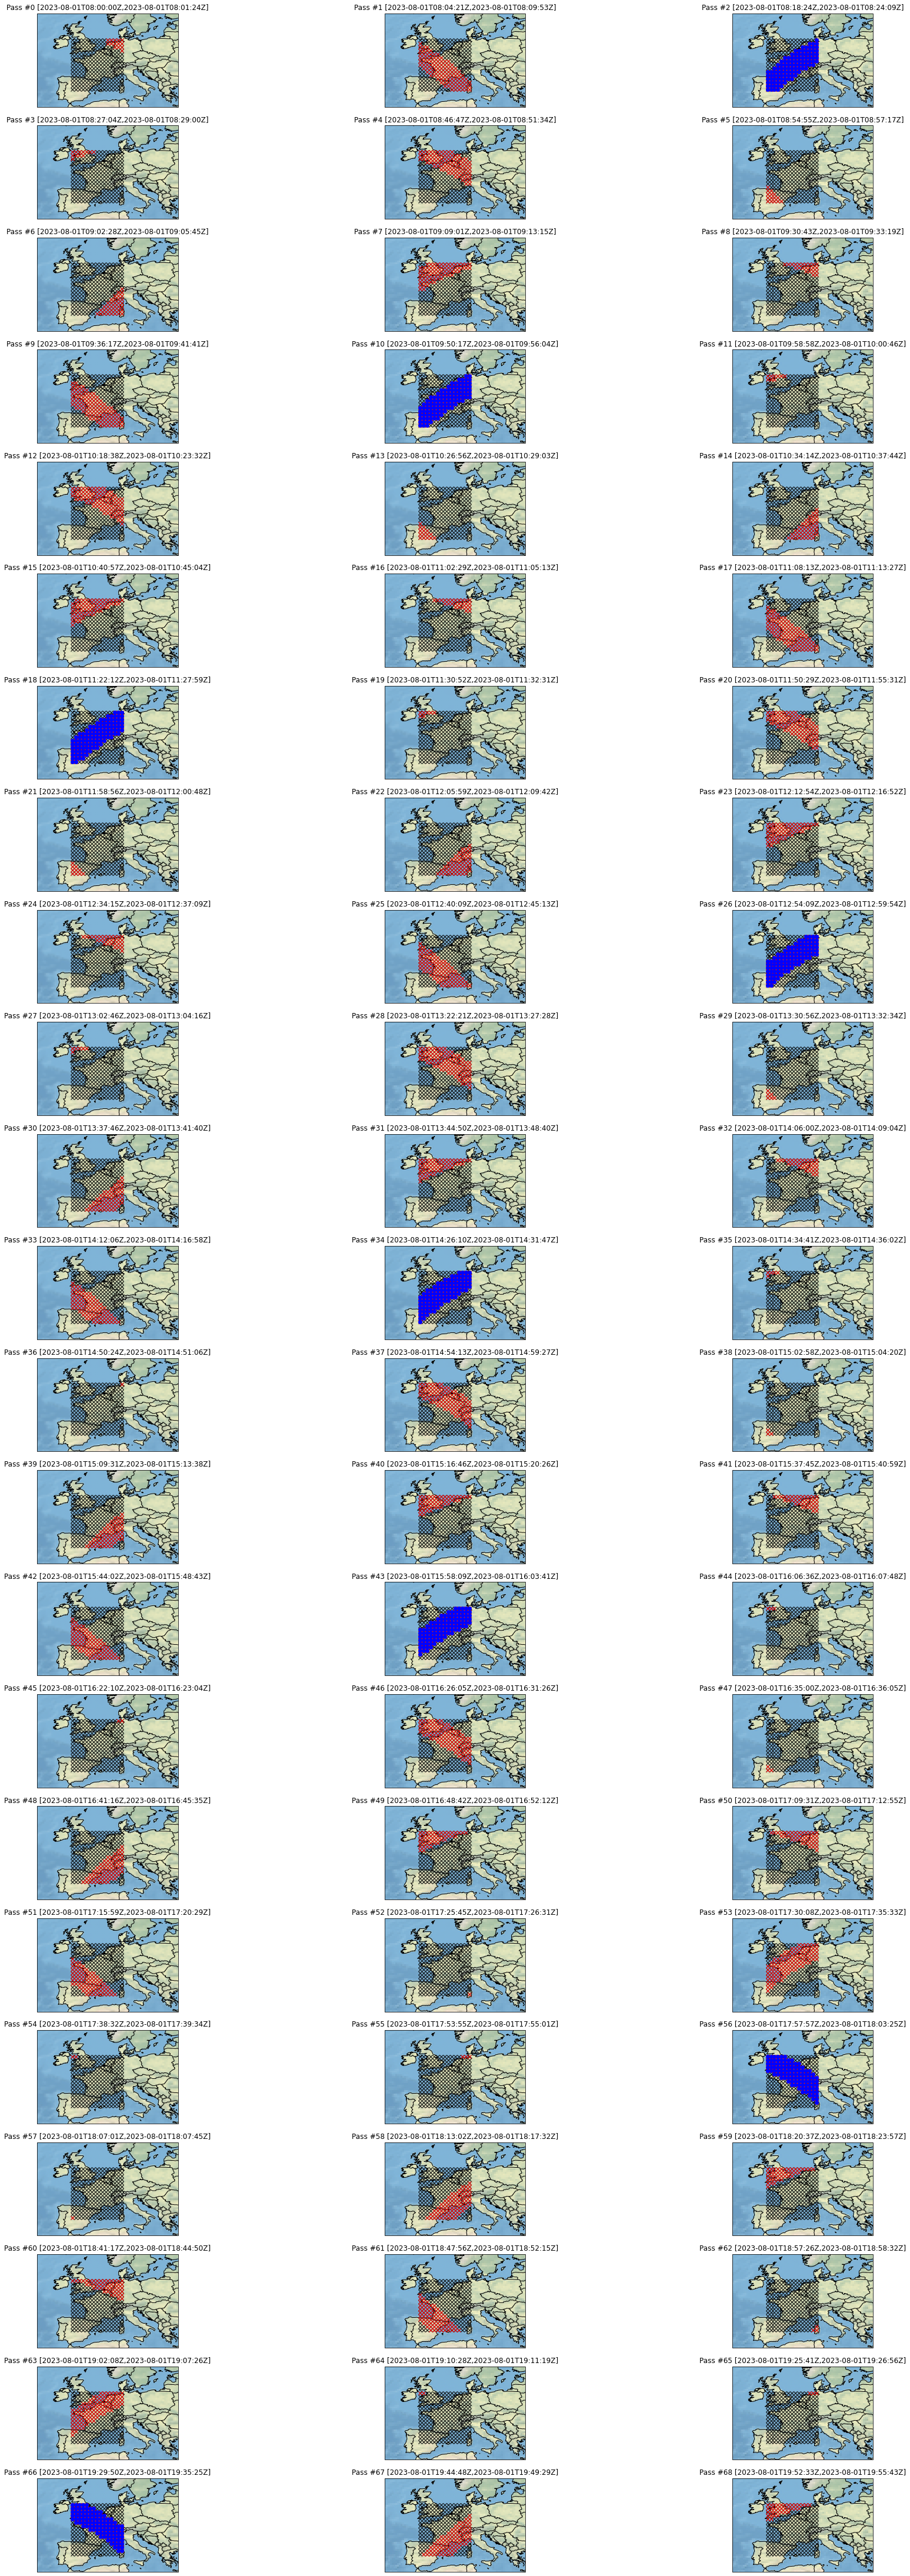

In [10]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 3

EXPLAIN

In [ ]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)

# Parameters
maxBudget = 2700 # Modify if required

# We start considering all the AOIs uncovered
covered = [False for i in range(nObsRequests)]



# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
selectedPassIds = model.binary_var_list(range(nPasses),name='selectedPassIds')
#??? timeSelectedPass = model.continious_var_matrix(range(nObsRequests),name='timeSelectedPass')

# Objectif
#??? model.minimize(len(selectedPassIds)*data['fixedPassCost'] + sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])*data['passCostPerTimeUnit'])
# Maximise the priority

# Contraints:
# 1) Minimum time
# model.add_constraint(     >= 30)

# 2) Cost below maximum budget
# model.add_constraint(     <= maxBudget)


# Solve
# solution = model.solve(log_output=True)


# a very basic solver
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# OLD: Start
# Computation of the total cost
timeCost = sum([satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds])
totalCost = len(selectedPassIds)*data['fixedPassCost'] + timeCost*data['passCostPerTimeUnit']

# Computation of the quality of the covering
quality = 0

print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))
#OLD: End

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)